# Building Pulse Schedulers
 - Pulse gates - define low-level, exact repr. for a circuit gate
 - Single operation = a pulse program = multiple low-level instructions
 - Pulse programs - called `Schedule`s - describe instruction seq. for control electronics
 - Build `Schedule`s with Pulse Builder:

In [1]:
from qiskit import pulse

with pulse.build(name='lg_example') as lg_prog:
    # Instructions go here
    pass
lg_prog

ScheduleBlock(, name="lg_example", transform=AlignLeft())

In [4]:
from qiskit.providers.fake_provider import FakeValencia

backend = FakeValencia()

with pulse.build(backend=backend, name='backend_aware') as backend_aware_program:
    channel = pulse.drive_channel(0)
    print(pulse.num_qubits())

5


## `delay`
- Blocking instruction - control electronics output no signal - on given channel for duration specified
- Useful to control timing of other instructions
- Pass duration and channel - use `pulse.build` to begin Pulse Builder context:

In [5]:
with pulse.build(backend) as delay_5dt:
    pulse.delay(5, channel)

## `play`
- Executes pulses
`with pulse.build() as sched:
    pulse.play(pulse, channel)`
### Pulses
- `Pulse` specifies arb. pulse envelope
- Modulation freq. and phase controlled by `set_frequency` & `shift_phase` instructions:

In [6]:
from qiskit.pulse import library

amp = 1
sigma = 10
num_samples = 128

### Parametric pulses
- When parameterized the job is smaller - may allow you to run larger programs
- E.g. Gaussian pulse:

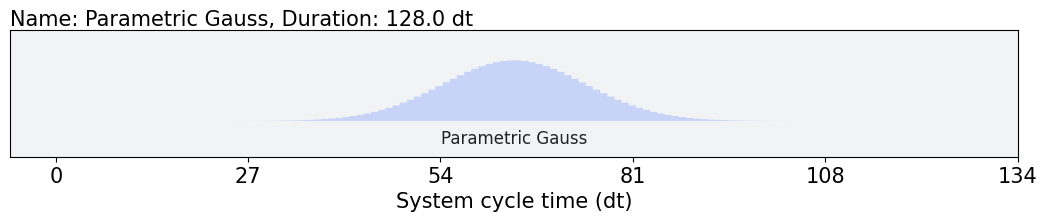

In [7]:
gaus = pulse.library.Gaussian(num_samples, amp, sigma,
                             name = 'Parametric Gauss')
gaus.draw()

### Pulse waveforms described by samples
- `Waveform` is a pulse specified as an array - time-ordered complex amplitudes - aka samples
- Each sample - played for 1 cycle - timestep `dt` - determined by backend
- $i^{th}$ sample will play from time `i*dt` to `(i+1)*dt`, modulated by qubit frequency

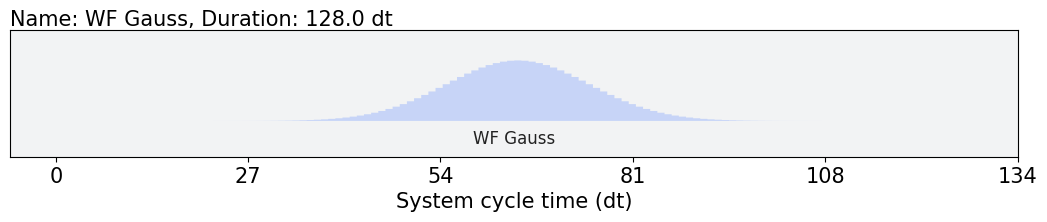

In [10]:
import numpy as np

times = np.arange(num_samples)
gaussian_samples = np.exp(-1/2 * ((times - num_samples / 2) ** 2/sigma**2))

gauss = library.Waveform(gaussian_samples, name='WF Gauss')
gauss.draw()

### Pulse library methods

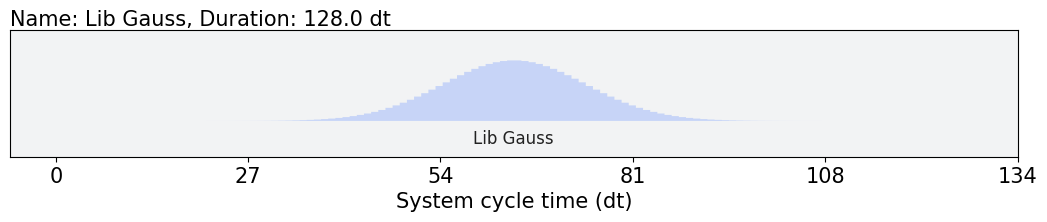

In [11]:
gauss = library.gaussian(duration=num_samples, amp=amp, sigma=sigma, name='Lib Gauss')
gauss.draw()

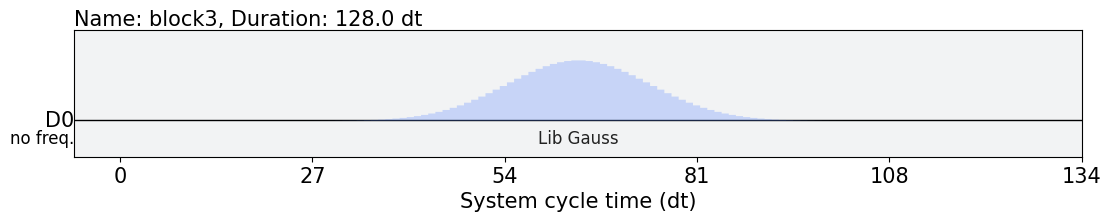

In [12]:
with pulse.build() as schedule:
    pulse.play(gauss, channel)
schedule.draw()

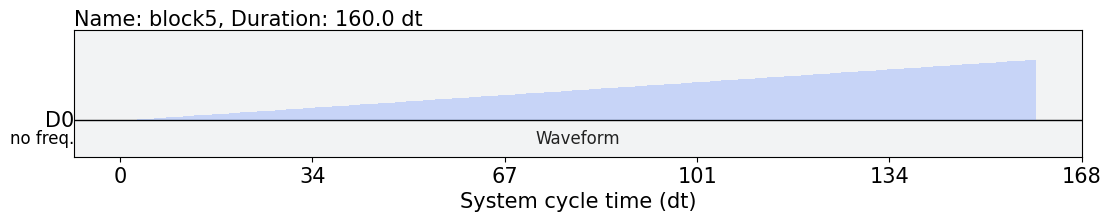

In [14]:
with pulse.build() as schedule:
    pulse.play([0.001*i for i in range(160)], channel)
schedule.draw()

## `set_frequency`
- Each channel has default frequency listed in `backend.defaults()`
- Channel modulation frequency - can be updated any time within a`Schedule`
- Frequency stays the same until another `set_frequency` is encountered - or program ends
- Implicit duration of `0`

In [15]:
with pulse.build(backend) as schedule:
    pulse.set_frequency(4.5e9, channel)

In [18]:
print(backend.defaults())

<PulseDefaults(<InstructionScheduleMap(1Q instructions:
  q0: {'x', 'u3', 'u1', 'sx', 'u2', 'id', 'measure', 'rz'}
  q1: {'x', 'u3', 'u1', 'sx', 'u2', 'id', 'measure', 'rz'}
  q2: {'x', 'u3', 'u1', 'sx', 'u2', 'id', 'measure', 'rz'}
  q3: {'x', 'u3', 'u1', 'sx', 'u2', 'id', 'measure', 'rz'}
  q4: {'x', 'u3', 'u1', 'sx', 'u2', 'id', 'measure', 'rz'}
Multi qubit instructions:
  (0, 1): {'cx'}
  (1, 0): {'cx'}
  (1, 2): {'cx'}
  (1, 3): {'cx'}
  (2, 1): {'cx'}
  (3, 1): {'cx'}
  (3, 4): {'cx'}
  (4, 3): {'cx'}
  (0, 1, 2, 3, 4): {'measure'}
)>Qubit Frequencies [GHz]
[4.743892440131272, 4.660914072609433, 4.792493277895261, 4.834410370035304, 4.959527978256725]
Measurement Frequencies [GHz]
[7.291423281, 7.064734703, 7.209148181000001, 7.137515922, 6.984029338] )>


## `acquire`
- triggers data acquisition for readout
- Args - duration, `AcquireChannel`, `MemorySlot`/`RegisterSlot`
    - `AcquireChannel` - maps to qubits being measured
    - `MemorySlot` - classical memory for readout storage
    - `RegisterSlot` - maps to register inc ontrol electronics - stored readout results for fast feedback
- Custom `Disctriminator` and `Kernel` are kwargs

In [19]:
from qiskit.pulse import Acquire, AcquireChannel, MemorySlot

with pulse.build(backend) as schedule:
    pulse.acquire(1200, pulse.acquire_channel(0), MemorySlot(0))

## Pulse Builder
- Control exactly when to play `Schedule` intructions

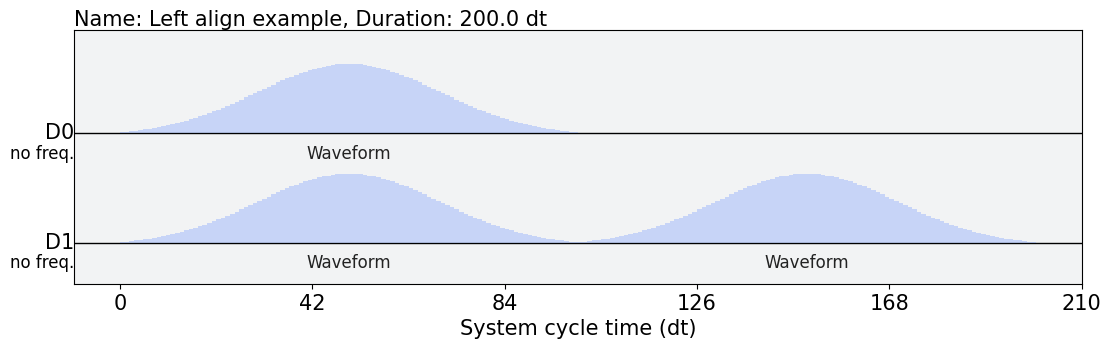

In [20]:
with pulse.build(backend=backend, name='Left align example') as program:
    with pulse.align_left():
        gaussian_pulse = library.gaussian(100, 0.5, 20)
        pulse.play(gaussian_pulse, pulse.drive_channel(0))
        pulse.play(gaussian_pulse, pulse.drive_channel(1))
        pulse.play(gaussian_pulse, pulse.drive_channel(1))
program.draw()

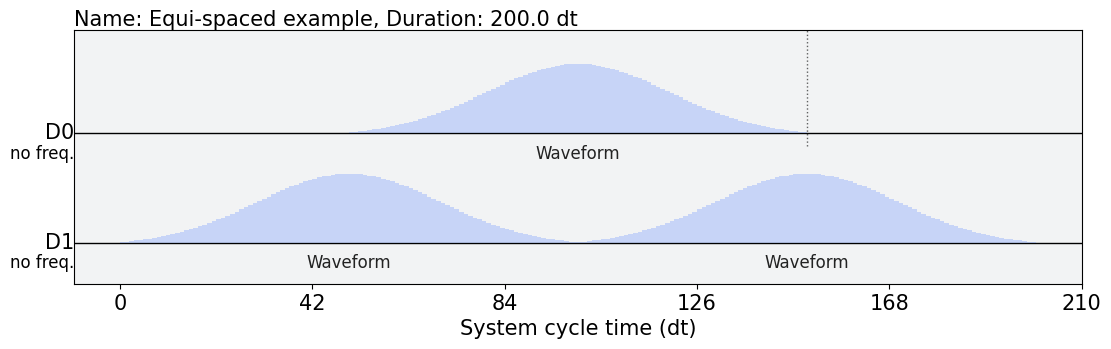

In [31]:
with pulse.build(backend=backend, name='Equi-spaced example') as program:
    gaussian_pulse = library.gaussian(100, 0.5, 20)
    with pulse.align_equispaced(int( 1.5*gaussian_pulse.duration)):
        pulse.play(gaussian_pulse, pulse.drive_channel(0))
    pulse.play(gaussian_pulse, pulse.drive_channel(1))
    pulse.play(gaussian_pulse, pulse.drive_channel(1))
program.draw()

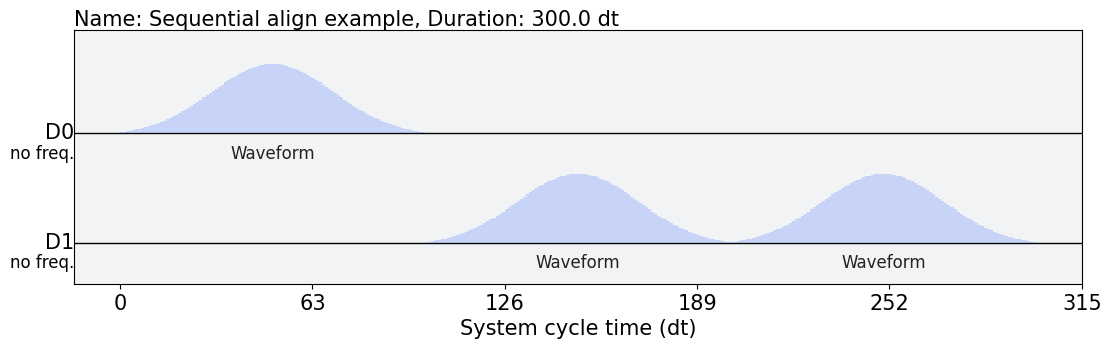

In [33]:
with pulse.build(backend, name='Sequential align example') as program:
    with pulse.align_sequential():
        gaussian_pulse = library.gaussian(100, 0.5, 20)
        pulse.play(gaussian_pulse, pulse.drive_channel(0))
        pulse.play(gaussian_pulse, pulse.drive_channel(1))
        pulse.play(gaussian_pulse, pulse.drive_channel(1))
program.draw()

### Phase & frequency offsets

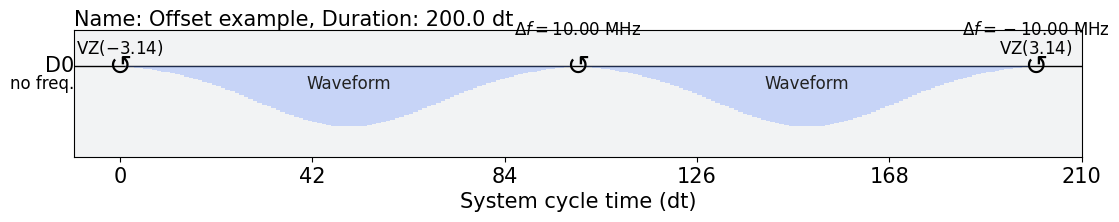

In [35]:
with pulse.build(backend, name='Offset example') as program:
    with pulse.phase_offset(3.14, pulse.drive_channel(0)):
        pulse.play(gaussian_pulse, pulse.drive_channel(0))
        with pulse.frequency_offset(10e6, pulse.drive_channel(0)):
            pulse.play(gaussian_pulse, pulse.drive_channel(0))
program.draw()